# 导入函数库

In [1]:
import torch
import gym
import numpy as np
import matplotlib.pyplot as plt

In [2]:
torch.set_default_dtype(torch.float64)

在策略梯度中，存在方差却没有偏差，所以导致了效果可能是优于了A-C算法（红框中为Critic），实际运行结果认为，A-C算法收敛性不稳定，曲线不美观

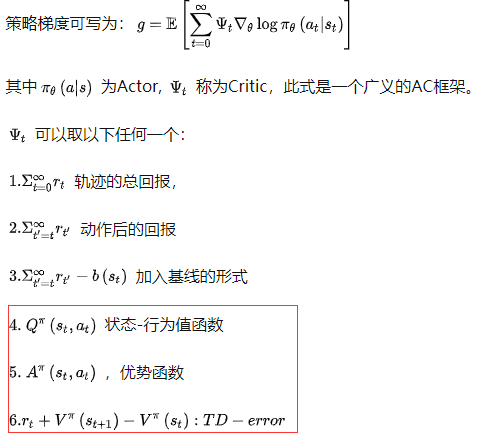

# Actor-Critic算法1-TD_error相关

## Actor网络

In [3]:
class actor:
  def __init__(self, env, hidden_dimension=20, learning_rate=1e-3):
    self.env = env
    self.hidden_dimension = hidden_dimension
    self.learning_rate = learning_rate

    self.state_dimension = self.env.observation_space.shape[0]
    try:self.action_dimension = self.env.action_space.shape[0]
    except:self.action_dimension = self.env.action_space.n

    self.model = self.__create_network()
    self.entropy = torch.nn.CrossEntropyLoss(reduction='none')
    self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)

  def __create_network(self):
    return torch.nn.Sequential(torch.nn.Linear(self.state_dimension, self.hidden_dimension),
                               torch.nn.ReLU(),
                               torch.nn.Linear(self.hidden_dimension, self.action_dimension),
                               torch.nn.Softmax(dim=-1)
                               )
  
  def output_action(self, state):
    state = torch.from_numpy(state)
    action_probablity_value = self.model(state)
    return np.random.choice(np.arange(self.action_dimension),
                            p=action_probablity_value.tolist())

  def learn(self, state, action, value):
    state = torch.from_numpy(state)
    action = torch.tensor(action)
    value = torch.tensor(value)

    action_probablity_value = self.model(state)
    log_probablity = torch.log(action_probablity_value[action])
    
    loss = -torch.mean(log_probablity * value)

    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()
    return loss.item()


## Critic网络

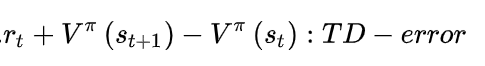

In [4]:
class critic:
  def __init__(self, env, hidden_dimension=20, learning_rate=1e-2, gamma=0.9):
    self.env = env
    self.hidden_dimension = hidden_dimension
    self.learning_rate = learning_rate
    self.gamma = gamma

    self.state_dimension = self.env.observation_space.shape[0]
    try:self.action_dimension = self.env.action_space.shape[0]
    except:self.action_dimension = 1

    self.model = self.__create_network()
    self.mse_loss = torch.nn.MSELoss()
    self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)


  def __create_network(self):
    return torch.nn.Sequential(torch.nn.Linear(self.state_dimension, self.hidden_dimension),
                               torch.nn.ReLU(),
                               torch.nn.Linear(self.hidden_dimension, self.action_dimension)
                               )

  def learn(self, state, reward, next_state):
    state = torch.from_numpy(state)
    reward = torch.tensor(reward)
    next_state = torch.from_numpy(next_state)

    value_next = self.model(next_state).detach()
    value = self.model(state)

    error = reward + self.gamma * value_next - value
    loss = torch.square(error)

    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()
    return np.array(error.tolist())

## Actor-Critic交互

In [8]:
class agent_actor_critic:
  def __init__(self, env_name="CartPole-v0", epoch=1000):
    self.env_name = env_name
    self.epoch = epoch

    self.env = gym.make(self.env_name)
    self.critic_network = critic(self.env)
    self.actor_network = actor(self.env)

  def start_execute(self):
    self.statistic_reward = []
    for i in range(self.epoch):
      state = self.env.reset()
      reward_total = 0
      while True:
        action = self.actor_network.output_action(state)
        next_state, reward, done, info = self.env.step(action)
        if done:
          reward -= 20
        reward_total += reward
        td_error = self.critic_network.learn(state, reward, next_state)
        loss = self.actor_network.learn(state, action, td_error)
        state = next_state
        if done:
          break
      self.statistic_reward.append(reward_total)
      if i % 10 == 0:
        print('\r, epoch %-4d, total_reward %s, loss = %s, td_error = %s' \
              %(i, reward_total, loss, td_error), end='')


## 智能体交互测试

In [ ]:
test_actor_critic = agent_actor_critic()
test_actor_critic.start_execute()

, epoch 160 , total_reward 180.0, loss = -4.251847241709741, td_error = [-20.12895717]

In [ ]:
%debug

# Actor-Critic算法2-Q相关

## Actor-2

In [ ]:
class actor2:
  def __init__(self, env, hidden_dimension=20, learning_rate=1e-3):
    self.env = env
    self.hidden_dimension = hidden_dimension
    self.learning_rate = learning_rate

    self.state_dimension = self.env.observation_space.shape[0]
    try:self.action_dimension = self.env.action_space.shape[0]
    except:self.action_dimension = self.env.action_space.n

    self.model = self.__create_network()
    self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
    self.entropy = torch.nn.CrossEntropyLoss(reduction='none')

  def __create_network(self):
    return torch.nn.Sequential(torch.nn.Linear(self.state_dimension, self.hidden_dimension),
                               torch.nn.ReLU(),
                               torch.nn.Linear(self.hidden_dimension, self.action_dimension),
                               )
  
  def output_action(self, state):
    state = torch.from_numpy(state)
    action_probablity_value = self.model(state)
    action_probablity_value = torch.nn.functional.softmax(action_probablity_value, dim=-1)
    return np.random.choice(np.arange(self.action_dimension),
                            p=action_probablity_value.tolist())

  def learn(self, state, action, value):
    state = torch.from_numpy(state.reshape(1,4))
    action = torch.tensor([action])
    value = torch.tensor(value)

    action_probablity_value = self.model(state)
    # loss = torch.log(torch.nn.functional.softmax(action_probablity_value, dim=-1)[0])[action]
    # loss = -loss * value
    loss = self.entropy(action_probablity_value, action) * value

    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()
    return loss.item()


## Critic-2

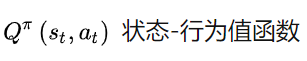

In [ ]:
class critic2:
  def __init__(self, env, hidden_dimension=20, learning_rate=1e-2, gamma=0.9):
    self.env = env
    self.hidden_dimension = hidden_dimension
    self.learning_rate = learning_rate
    self.gamma = gamma

    self.state_dimension = self.env.observation_space.shape[0]
    try:self.action_dimension = self.env.action_space.shape[0]
    except:self.action_dimension = self.env.action_space.n

    self.model = self.__create_network()
    self.mse_loss = torch.nn.MSELoss()
    self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)

  def __create_network(self):
    return torch.nn.Sequential(torch.nn.Linear(self.state_dimension, self.hidden_dimension),
                               torch.nn.ReLU(),
                               torch.nn.Linear(self.hidden_dimension, self.action_dimension)
                               )

  def learn(self, state, action, reward, next_state):
    state = torch.from_numpy(state)
    action = torch.tensor(action)
    reward = torch.tensor(reward)
    next_state = torch.from_numpy(next_state)

    value_next = self.model(next_state).detach()
    value = self.model(state)

    error = reward + self.gamma * torch.max(value_next) - value[action]
    loss = torch.square(error)

    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()
    return value[action].tolist()

In [ ]:
class agent_actor_critic2:
  def __init__(self, env_name="CartPole-v0", epoch=1000):
    self.env_name = env_name
    self.epoch = epoch

    self.env = gym.make(self.env_name)
    self.critic_network = critic2(self.env)
    self.actor_network = actor2(self.env)

  def start_execute(self):
    self.statistic_reward = []
    for i in range(self.epoch):
      state = self.env.reset()
      reward_total = 0
      while True:
        action = self.actor_network.output_action(state)
        next_state, reward, done, info = self.env.step(action)
        if done:
          reward -= 20
        reward_total += reward
        td_error = self.critic_network.learn(state, action, reward, next_state)
        loss = self.actor_network.learn(state, action, td_error)
        state = next_state
        if done:
          break
      self.statistic_reward.append(reward_total)
      if i % 10 == 0:
        print('\r, epoch %-4d, total_reward %s, loss = %s, td_error = %s' \
              %(i, reward_total, loss, td_error), end='')


## 效果测试

In [ ]:
test_actor_critic2 = agent_actor_critic2()
test_actor_critic2.start_execute()

, epoch 990 , total_reward -9.0, loss = 0.7764777682686155, td_error = 2580.3925121423017

有时候可能完全不收敛，或者收敛一半就发散，loss乱跑。如下图呢

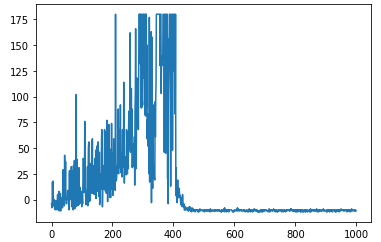

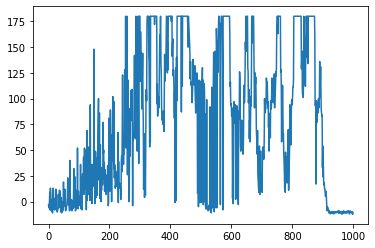

In [ ]:
plt.plot(test_actor_critic2.statistic_reward)

In [ ]:
plt.plot(test_actor_critic.statistic_reward)

In [ ]:
%debug

> <ipython-input-143-1875d053de7c>(34)learn()
     32 
     33     action_probablity_value = self.model(state)
---> 34     loss = torch.log(torch.nn.functional.softmax(action_probablity_value, dim=-1))[action]
     35 
     36     loss = -loss * value

ipdb> torch.nn.functional.softmax(action_probablity_value, dim=-1)
tensor([[0.4723, 0.5277]], grad_fn=<SoftmaxBackward>)
ipdb> q


# Advantage Actor-Critic算法

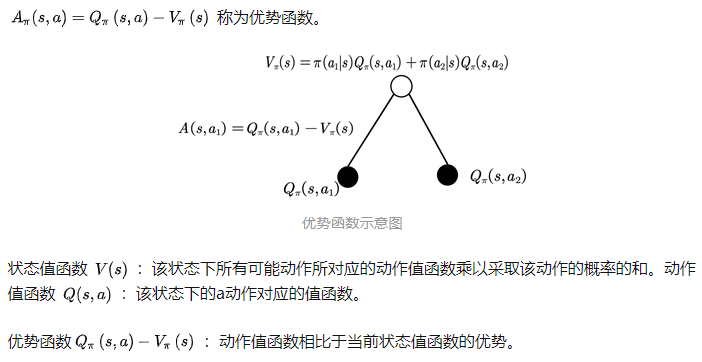

## Actor-3

In [ ]:
class actor3:
  def __init__(self, env, hidden_dimension=20, learning_rate=1e-3):
    self.env = env
    self.hidden_dimension = hidden_dimension
    self.learning_rate = learning_rate

    self.state_dimension = self.env.observation_space.shape[0]
    try:self.action_dimension = self.env.action_space.shape[0]
    except:self.action_dimension = self.env.action_space.n

    self.model = self.__create_network()
    self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
    self.entropy = torch.nn.CrossEntropyLoss(reduction='none')

  def __create_network(self):
    return torch.nn.Sequential(torch.nn.Linear(self.state_dimension, self.hidden_dimension),
                               torch.nn.ReLU(),
                               torch.nn.Linear(self.hidden_dimension, self.action_dimension),
                               )
  
  def output_action(self, state):
    state = torch.from_numpy(state)
    action_probablity_value = self.model(state)
    action_probablity_value = torch.nn.functional.softmax(action_probablity_value, dim=-1)
    return np.random.choice(np.arange(self.action_dimension),
                            p=action_probablity_value.tolist())

  def learn(self, state, action, value):
    state = torch.from_numpy(state.reshape(1,4))
    action = torch.tensor([action])
    value = torch.from_numpy(value)

    action_probablity_value = self.model(state)
    action_probablity = torch.nn.functional.softmax(action_probablity_value, dim=-1)
    value_all = torch.sum(action_probablity * value)

    advantage = value[action] - value_all

    loss = self.entropy(action_probablity_value, action) * advantage

    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()
    return loss.item()


## Critic-3

In [ ]:
class critic3:
  def __init__(self, env, hidden_dimension=20, learning_rate=1e-2, gamma=0.9):
    self.env = env
    self.hidden_dimension = hidden_dimension
    self.learning_rate = learning_rate
    self.gamma = gamma

    self.state_dimension = self.env.observation_space.shape[0]
    try:self.action_dimension = self.env.action_space.shape[0]
    except:self.action_dimension = self.env.action_space.n

    self.model = self.__create_network()
    self.mse_loss = torch.nn.MSELoss()
    self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)

  def __create_network(self):
    return torch.nn.Sequential(torch.nn.Linear(self.state_dimension, self.hidden_dimension),
                               torch.nn.ReLU(),
                               torch.nn.Linear(self.hidden_dimension, self.action_dimension)
                               )

  def learn(self, state, action, reward, next_state):
    state = torch.from_numpy(state)
    action = torch.tensor(action)
    reward = torch.tensor(reward)
    next_state = torch.from_numpy(next_state)

    value_next = self.model(next_state).detach()
    value = self.model(state)

    error = reward + self.gamma * torch.max(value_next) - value[action]
    loss = torch.square(error)

    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()
    return np.array(value.tolist())

## 智能体交互

In [ ]:
class agent_actor_critic3:
  def __init__(self, env_name="CartPole-v0", epoch=1000):
    self.env_name = env_name
    self.epoch = epoch

    self.env = gym.make(self.env_name)
    self.critic_network = critic3(self.env)
    self.actor_network = actor3(self.env)

  def start_execute(self):
    self.statistic_reward = []  
    for i in range(self.epoch):
      state = self.env.reset()
      reward_total = 0
      while True:
        action = self.actor_network.output_action(state)
        next_state, reward, done, info = self.env.step(action)
        if done:
          reward -= 20
        reward_total += reward
        td_error = self.critic_network.learn(state, action, reward, next_state)
        loss = self.actor_network.learn(state, action, td_error)
        state = next_state
        if done:
          break
      self.statistic_reward.append(reward_total)
      if i % 10 == 0:
        print('\r, epoch %-4d, total_reward %s, loss = %s, td_error = %s' \
              %(i, reward_total, loss, td_error), end='')


In [ ]:
test_actor_critic3 = agent_actor_critic3()
test_actor_critic3.start_execute()

, epoch 990 , total_reward 89.0, loss = 0.003424950811387289, td_error = [-10.23123027 -15.18297277]

## 效果测试

In [ ]:
plt.plot(test_actor_critic3.statistic_reward)

# 整体对比

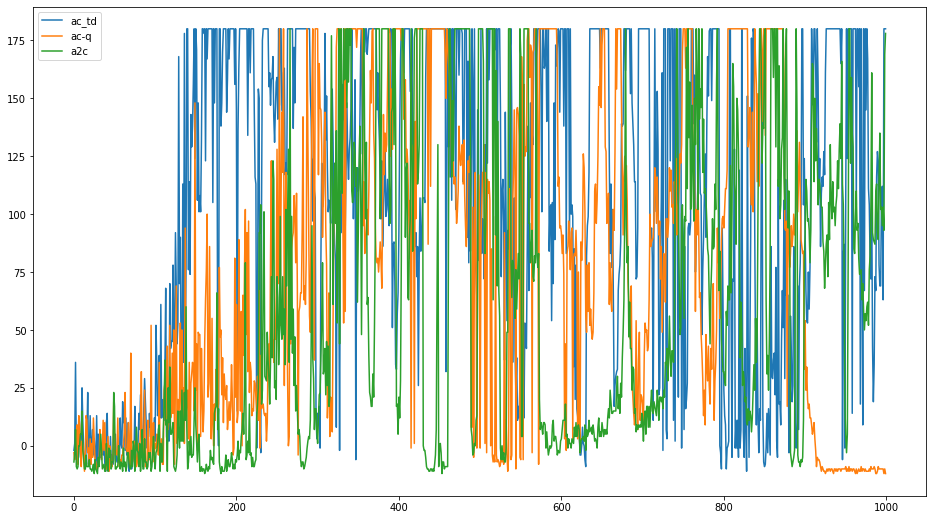

In [ ]:
fig = plt.figure(figsize=(16,9))
ax1 = fig.add_subplot(111)
ax1.plot(test_actor_critic.statistic_reward)
ax1.plot(test_actor_critic2.statistic_reward)
ax1.plot(test_actor_critic3.statistic_reward)
ax1.legend(['ac_td','ac-q','a2c'])

In [ ]:
def normalize_reward(rewad_array, batch=50):
  reward_return = np.zeros(int(len(rewad_array)/batch))
  i = 0
  for reward in rewad_array:
    reward_return[i//batch] += reward
    i += 1
  reward_return /= batch
  return reward_return


In [ ]:
reward = normalize_reward(test_actor_critic.statistic_reward)
reward2 = normalize_reward(test_actor_critic2.statistic_reward)
reward3 = normalize_reward(test_actor_critic3.statistic_reward)

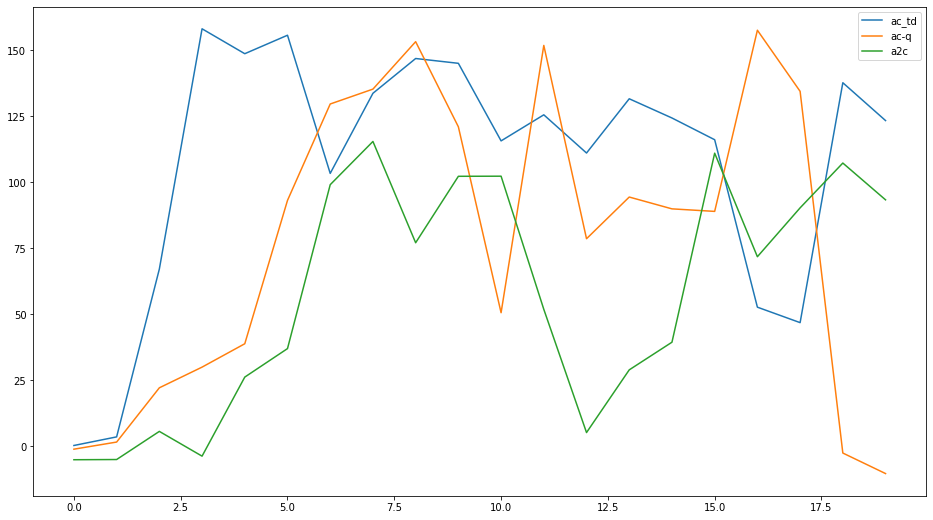

In [ ]:
fig = plt.figure(figsize=(16,9))
ax2 = fig.add_subplot(111)
ax2.plot(reward)
ax2.plot(reward2)
ax2.plot(reward3)
ax2.legend(['ac_td','ac-q','a2c'])

# 测试工具

## 测试代码1

In [ ]:

import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior
tf.compat.v1.disable_eager_execution()
tf.reset_default_graph()
import gym
import pandas as pd

OUTPUT_GRAPH = False
MAX_EPISODE = 5000
DISPLAY_REWARD_THRESHOLD = 200  # renders environment if total episode reward is greater then this threshold
MAX_EP_STEPS = 2000  # maximum time step in one episode
RENDER = False  # rendering wastes time
GAMMA = 0.9  # reward discount in TD error
LR_A = 0.001  # learning rate for actor
LR_C = 0.001  # learning rate for critic


class Actor(object):
    def __init__(self, sess, n_features, n_actions, lr=0.001):
        self.sess = sess

        self.s = tf.placeholder(tf.float32, [1, n_features], "state")
        self.a = tf.placeholder(tf.int32, None, "action")
        self.q = tf.placeholder(tf.float32, None, "q")  # TD_error

        with tf.variable_scope('Actor'):
            l1 = tf.layers.dense(
                inputs=self.s,
                units=20,  # number of hidden units
                activation=tf.nn.relu,
                kernel_initializer=tf.random_normal_initializer(0., .1),  # weights
                bias_initializer=tf.constant_initializer(0.1),  # biases
                name='l1'
            )

            self.acts_prob = tf.layers.dense(
                inputs=l1,
                units=n_actions,  # output units
                activation=tf.nn.softmax,  # get action probabilities
                kernel_initializer=tf.random_normal_initializer(0., .1),  # weights
                bias_initializer=tf.constant_initializer(0.1),  # biases
                name='acts_prob'
            )

        with tf.variable_scope('exp_v'):
            log_prob = tf.log(self.acts_prob[0, self.a])
            self.exp_v = tf.reduce_mean(log_prob * self.q)  # advantage (TD_error) guided loss

        with tf.variable_scope('train'):
            self.train_op = tf.train.AdamOptimizer(lr).minimize(-self.exp_v)  # minimize(-exp_v) = maximize(exp_v)

    def learn(self, s, a, q):
        s = s[np.newaxis, :]
        feed_dict = {self.s: s, self.a: a, self.q: q}
        _, exp_v = self.sess.run([self.train_op, self.exp_v], feed_dict)
        return exp_v

    def choose_action(self, s):
        s = s[np.newaxis, :]
        probs = self.sess.run(self.acts_prob, {self.s: s})  # get probabilities for all actions
        return np.random.choice(np.arange(probs.shape[1]), p=probs.ravel())  # return a int


class Critic(object):
    def __init__(self, sess, n_features,n_actions, lr=0.01):
        self.sess = sess

        self.s = tf.placeholder(tf.float32, [None, n_features], "state")
        self.a = tf.placeholder(tf.int32,[None, 1],"action")
        self.r = tf.placeholder(tf.float32, None, 'r')
        self.q_ = tf.placeholder(tf.float32,[None,1],'q_next')

        self.a_onehot = tf.one_hot(self.a, n_actions, dtype=tf.float32)
        self.a_onehot = tf.squeeze(self.a_onehot,axis=1)

        self.input = tf.concat([self.s,self.a_onehot],axis=1)
        
        with tf.variable_scope('Critic'):
            l1 = tf.layers.dense(
                inputs=self.input,
                units=20,  # number of hidden units
                activation=tf.nn.relu,  # None
                kernel_initializer=tf.random_normal_initializer(0., .1),  # weights
                bias_initializer=tf.constant_initializer(0.1),  # biases
                name='l1'
            )

            self.q = tf.layers.dense(
                inputs=l1,
                units=1,  # output units
                activation=None,
                kernel_initializer=tf.random_normal_initializer(0., .1),  # weights
                bias_initializer=tf.constant_initializer(0.1),  # biases
                name='Q'
            )

        with tf.variable_scope('squared_TD_error'):
            self.td_error = self.r + GAMMA * self.q_ - self.q
            self.loss = tf.square(self.td_error)  # TD_error = (r+gamma*V_next) - V_eval
        with tf.variable_scope('train'):
            self.train_op = tf.train.AdamOptimizer(lr).minimize(self.loss)

    def learn(self, s, a, r, s_):
        s, s_ = s[np.newaxis, :], s_[np.newaxis, :]
        next_a = [[i] for i in range(N_A)]
        s_ = np.tile(s_,[N_A,1])

        q_ = self.sess.run(self.q, {self.s: s_,self.a:next_a})
        q_ = np.max(q_,axis=0,keepdims=True)
        q, _ = self.sess.run([self.q, self.train_op],
                                    {self.s: s, self.q_: q_, self.r: r,self.a:[[a]]})
        return q


env = gym.make('CartPole-v0')
env.seed(1)  # reproducible
env = env.unwrapped

N_F = env.observation_space.shape[0]
N_A = env.action_space.n

sess = tf.Session()

actor = Actor(sess, n_features=N_F, n_actions=N_A, lr=LR_A)
critic = Critic(sess, n_features=N_F,n_actions=N_A,lr=LR_C)

sess.run(tf.global_variables_initializer())

res = []
for i_episode in range(MAX_EPISODE):
    s = env.reset()
    t = 0
    track_r = []
    while True:
        a = actor.choose_action(s)
        s_, r, done, info = env.step(a)
        if done: r = -20

        track_r.append(r)

        q = critic.learn(s, a,r, s_)  # gradient = grad[r + gamma * V(s_) - V(s)]
        actor.learn(s, a, q)  # true_gradient = grad[logPi(s,a) * td_error]

        s = s_
        t += 1

        if done or t >= MAX_EP_STEPS:
            ep_rs_sum = sum(track_r)

            if 'running_reward' not in globals():
                running_reward = ep_rs_sum
            else:
                running_reward = running_reward * 0.95 + ep_rs_sum * 0.05
            if i_episode % 100 == 0:
              print("episode:", i_episode, "  reward:", int(running_reward))
            
            res.append([i_episode,running_reward])

            break

pd.DataFrame(res,columns=['episode','ac_reward']).to_csv('../ac_reward.csv')



## 测试代码2

In [ ]:
import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior
tf.compat.v1.disable_eager_execution()
tf.reset_default_graph()
import gym
import pandas as pd

OUTPUT_GRAPH = False
MAX_EPISODE = 500
DISPLAY_REWARD_THRESHOLD = 200  # renders environment if total episode reward is greater then this threshold
MAX_EP_STEPS = 2000   # maximum time step in one episode
RENDER = False  # rendering wastes time
GAMMA = 0.9     # reward discount in TD error
LR_A = 0.001    # learning rate for actor
LR_C = 0.01     # learning rate for critic


class Actor(object):
    def __init__(self, sess, n_features, n_actions, lr=0.001):
        self.sess = sess

        self.s = tf.placeholder(tf.float32, [1, n_features], "state")
        self.a = tf.placeholder(tf.int32, None, "action")
        self.td_error = tf.placeholder(tf.float32, None, "td_error")  # TD_error

        with tf.variable_scope('Actor'):
            l1 = tf.layers.dense(
                inputs=self.s,
                units=20,    # number of hidden units
                activation=tf.nn.relu,
                kernel_initializer=tf.random_normal_initializer(0., .1),    # weights
                bias_initializer=tf.constant_initializer(0.1),  # biases
                name='l1'
            )

            self.acts_prob = tf.layers.dense(
                inputs=l1,
                units=n_actions,    # output units
                activation=tf.nn.softmax,   # get action probabilities
                kernel_initializer=tf.random_normal_initializer(0., .1),  # weights
                bias_initializer=tf.constant_initializer(0.1),  # biases
                name='acts_prob'
            )

        with tf.variable_scope('exp_v'):
            log_prob = tf.log(self.acts_prob[0, self.a])
            self.exp_v = tf.reduce_mean(log_prob * self.td_error)  # advantage (TD_error) guided loss

        with tf.variable_scope('train'):
            self.train_op = tf.train.AdamOptimizer(lr).minimize(-self.exp_v)  # minimize(-exp_v) = maximize(exp_v)

    def learn(self, s, a, td):
        s = s[np.newaxis, :]
        feed_dict = {self.s: s, self.a: a, self.td_error: td}
        _, exp_v = self.sess.run([self.train_op, self.exp_v], feed_dict)
        return exp_v

    def choose_action(self, s):
        s = s[np.newaxis, :]
        probs = self.sess.run(self.acts_prob, {self.s: s})   # get probabilities for all actions
        return np.random.choice(np.arange(probs.shape[1]), p=probs.ravel())   # return a int

class Critic(object):
    def __init__(self, sess, n_features, lr=0.01):
        self.sess = sess

        self.s = tf.placeholder(tf.float32, [1, n_features], "state")
        self.v_ = tf.placeholder(tf.float32, [1, 1], "v_next")
        self.r = tf.placeholder(tf.float32, None, 'r')

        with tf.variable_scope('Critic'):
            l1 = tf.layers.dense(
                inputs=self.s,
                units=20,  # number of hidden units
                activation=tf.nn.relu,  # None
                kernel_initializer=tf.random_normal_initializer(0., .1),  # weights
                bias_initializer=tf.constant_initializer(0.1),  # biases
                name='l1'
            )

            self.v = tf.layers.dense(
                inputs=l1,
                units=1,  # output units
                activation=None,
                kernel_initializer=tf.random_normal_initializer(0., .1),  # weights
                bias_initializer=tf.constant_initializer(0.1),  # biases
                name='V'
            )

        with tf.variable_scope('squared_TD_error'):
            self.td_error = self.r + GAMMA * self.v_ - self.v
            self.loss = tf.square(self.td_error)    # TD_error = (r+gamma*V_next) - V_eval
        with tf.variable_scope('train'):
            self.train_op = tf.train.AdamOptimizer(lr).minimize(self.loss)

    def learn(self, s, r, s_):
        s, s_ = s[np.newaxis, :], s_[np.newaxis, :]

        v_ = self.sess.run(self.v, {self.s: s_})
        td_error, _ = self.sess.run([self.td_error, self.train_op],
                                          {self.s: s, self.v_: v_, self.r: r})
        return td_error

# action有两个，即向左或向右移动小车
# state是四维

env = gym.make('CartPole-v0')
env.seed(1)  # reproducible
env = env.unwrapped

N_F = env.observation_space.shape[0]
N_A = env.action_space.n

sess = tf.Session()

actor = Actor(sess, n_features=N_F, n_actions=N_A, lr=LR_A)
critic = Critic(sess, n_features=N_F, lr=LR_C)

sess.run(tf.global_variables_initializer())

res = []
for i_episode in range(MAX_EPISODE):
    s = env.reset()
    t = 0
    track_r = []
    while True:
        a = actor.choose_action(s)
        s_, r, done, info = env.step(a)
        if done: r = -20
        track_r.append(r)
        td_error = critic.learn(s, r, s_)  # gradient = grad[r + gamma * V(s_) - V(s)]
        actor.learn(s, a, td_error)     # true_gradient = grad[logPi(s,a) * td_error]
        s = s_
        t += 1
        if done or t >= MAX_EP_STEPS:
            ep_rs_sum = sum(track_r)
            if 'running_reward' not in globals():
                running_reward = ep_rs_sum
            else:
                running_reward = running_reward * 0.95 + ep_rs_sum * 0.05
            if running_reward > DISPLAY_REWARD_THRESHOLD: RENDER = True  # rendering
            print("episode:", i_episode, "  reward:", int(running_reward))#ep_rs_sum
            res.append([i_episode, running_reward])
            break

pd.DataFrame(res,columns=['episode','a2c_reward']).to_csv('../a2c_reward.csv')



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


episode: 0   reward: 8
episode: 1   reward: 7
episode: 2   reward: 6
episode: 3   reward: 6
episode: 4   reward: 5
episode: 5   reward: 5
episode: 6   reward: 5
episode: 7   reward: 4
episode: 8   reward: 4
episode: 9   reward: 4
episode: 10   reward: 3
episode: 11   reward: 3
episode: 12   reward: 3
episode: 13   reward: 2
episode: 14   reward: 3
episode: 15   reward: 3
episode: 16   reward: 3
episode: 17   reward: 3
episode: 18   reward: 3
episode: 19   reward: 2
episode: 20   reward: 2
episode: 21   reward: 2
episode: 22   reward: 2
episode: 23   reward: 2
episode: 24   reward: 2
episode: 25   reward: 2
episode: 26   reward: 1
episode: 27   reward: 1
episode: 28   reward: 1
episode: 29   reward: 1
episode: 30   reward: 1
episode: 31   reward: 0
episode: 32   reward: 0
episode: 33   reward: 0
episode: 34   reward: 0
episode: 35   reward: 0
episode: 36   reward: 0
episode: 37   reward: 0
episode: 38   reward: 0
episode: 39   reward: 0
episode: 40   reward: 0
episode: 41   reward: 0
ep

KeyboardInterrupt: ignored